# ⚛️ H₂ VQE — Noisy Optimizer Comparison (Production API)

This notebook compares **classical optimizers** for **H₂ VQE** under different
**noise channels**, using only the **packaged VQE API**.

We will run **multi-seed noise statistics** and compare optimizers by:

- Mean and standard deviation of the **energy error**:  ΔE = E_noisy − E_ref
- Mean and standard deviation of the **fidelity** vs a noiseless reference state
- Across a grid of **noise strengths**

The key entry point used here is:

```python
from vqe.core import run_vqe_optimizer_comparison
```

---

## What this notebook does (and does not) do

✅ Uses **only** production package functions (no hand-built QNodes).  
✅ Uses **multi-seed statistics** for robustness.  
✅ Produces **overlay plots**: one curve per optimizer.  

❌ Does not manually implement VQE loops inside the notebook.  
❌ Does not implement new noise models beyond what the package already supports.

## 1️⃣ Imports and configuration

In [1]:
import numpy as np

from vqe.core import run_vqe_optimizer_comparison

### Experiment defaults

- Molecule: **H₂**
- Ansatz: **UCCSD**
- Mapping: **Jordan–Wigner**
- Noise grid: **0.00 → 0.10**
- Seeds: **0 → 9**

The runtime scales approximately with:

$$\text{cost} \sim N_{\text{optimizers}} \times N_{\text{noise}} \times N_{\text{seeds}} \times N_{\text{steps}}$$


In [ ]:
molecule = "H2"
ansatz_name = "UCCSD"
mapping = "jordan_wigner"

# Noise grid in [0.00, 0.10]
noise_levels = np.arange(0.0, 0.11, 0.02)

# Multi-seed statistics
seeds = np.arange(0, 10)

# Optimizers to compare
optimizers = ["Adam", "GradientDescent", "Momentum", "Nesterov", "RMSProp", "Adagrad"]

# Optimization parameters
steps = 50
stepsize_map = {
    "Adam": 0.2,
    "GradientDescent": 0.05,
    "Momentum": 0.1,
    "Nesterov": 0.1,
    "RMSProp": 0.1,
    "Adagrad": 0.2,
}

print("Noise levels:", noise_levels)
print("Seeds:", seeds)
print("Steps:", steps)
print("Stepsizes:", stepsize_map)


Noise levels: [0.   0.02 0.04 0.06 0.08 0.1 ]
Seeds: [0]
Steps: 25
Stepsizes: {'Adam': 0.2, 'GradientDescent': 0.05, 'Momentum': 0.1, 'Nesterov': 0.1, 'RMSProp': 0.1, 'Adagrad': 0.2}


## 2️⃣ Helper: simple robustness score

To summarise an optimizer’s robustness into a single number, we compute:

- **AUC(ΔE)** over the noise grid: smaller is better
- **AUC(1 − Fidelity)** over the noise grid: smaller is better

These are coarse summaries, but useful for quick ranking.

In [3]:
def auc_trapz(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    return float(np.trapz(y, x))

def summarise_noise_stats(result_dict):
    """
    Build a compact summary table from the output of
    run_vqe_optimizer_comparison(mode="noise_stats", ...).
    """
    x = np.asarray(result_dict["noise_levels"], dtype=float)
    rows = []
    for opt_name, data in result_dict["optimizers"].items():
        deltaE_mean = np.asarray(data["deltaE_mean"], dtype=float)
        fid_mean = np.asarray(data["fidelity_mean"], dtype=float)

        rows.append(
            {
                "optimizer": opt_name,
                "stepsize": float(data.get("stepsize", np.nan)),
                "AUC_deltaE": auc_trapz(x, np.abs(deltaE_mean)),
                "AUC_1_minus_fidelity": auc_trapz(x, 1.0 - fid_mean),
                "deltaE_at_max_noise": float(deltaE_mean[-1]),
                "fidelity_at_max_noise": float(fid_mean[-1]),
            }
        )

    # Sort by energy robustness then fidelity robustness
    rows = sorted(rows, key=lambda r: (r["AUC_deltaE"], r["AUC_1_minus_fidelity"]))
    return rows

def print_summary(rows, title):
    print("\n" + title)
    print("-" * len(title))
    header = f"{'optimizer':<18s} {'stepsize':>9s} {'AUC|ΔE|':>12s} {'AUC(1-F)':>12s} {'ΔE@max':>12s} {'F@max':>10s}"
    print(header)
    print("-" * len(header))
    for r in rows:
        print(
            f"{r['optimizer']:<18s} "
            f"{r['stepsize']:>9.3f} "
            f"{r['AUC_deltaE']:>12.6f} "
            f"{r['AUC_1_minus_fidelity']:>12.6f} "
            f"{r['deltaE_at_max_noise']:>12.6f} "
            f"{r['fidelity_at_max_noise']:>10.4f}"
        )

## 3️⃣ Depolarizing noise: optimizer comparison (multi-seed)

We sweep depolarizing probability `p` and set amplitude damping to zero:

- `noise_type="depolarizing"`
- `noise_levels = [0.00, 0.02, ..., 0.10]`

The package function will:
- compute per-seed noiseless references,
- run noisy VQE across seeds/noise levels for each optimizer,
- compute ΔE and fidelity mean/std,
- optionally generate **overlay plots** (one curve per optimizer).


⚙️ Optimizer: Adam (stepsize=0.2)
  🔹 Computing noiseless references per seed...
Step 01/25: E = -1.116684 Ha
Step 02/25: E = -1.136994 Ha
Step 03/25: E = -1.131007 Ha
Step 04/25: E = -1.126316 Ha
Step 05/25: E = -1.130447 Ha
Step 06/25: E = -1.135806 Ha
Step 07/25: E = -1.137141 Ha
Step 08/25: E = -1.134642 Ha
Step 09/25: E = -1.132264 Ha
Step 10/25: E = -1.132629 Ha
Step 11/25: E = -1.134929 Ha
Step 12/25: E = -1.136915 Ha
Step 13/25: E = -1.137116 Ha
Step 14/25: E = -1.135863 Ha
Step 15/25: E = -1.134713 Ha
Step 16/25: E = -1.134801 Ha
Step 17/25: E = -1.135915 Ha
Step 18/25: E = -1.137006 Ha
Step 19/25: E = -1.137229 Ha
Step 20/25: E = -1.136622 Ha
Step 21/25: E = -1.135949 Ha
Step 22/25: E = -1.135898 Ha
Step 23/25: E = -1.136466 Ha
Step 24/25: E = -1.137094 Ha
Step 25/25: E = -1.137255 Ha

💾 Saved run record to /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noiseless__s0__edc12961e9f5.json

  🔹 Sweeping noise levels...
Step 01/25: E = -1.116684 Ha


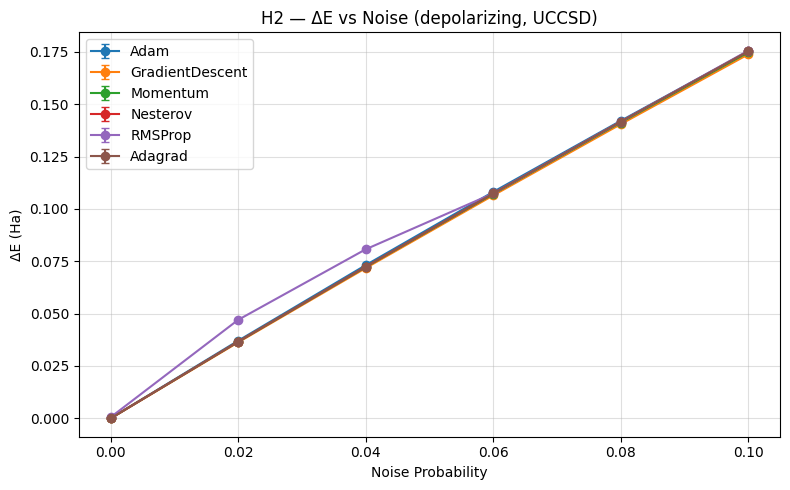

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2_noisy_optimizer_comparison_deltae_ansUCCSD_noisedepolarizing.png


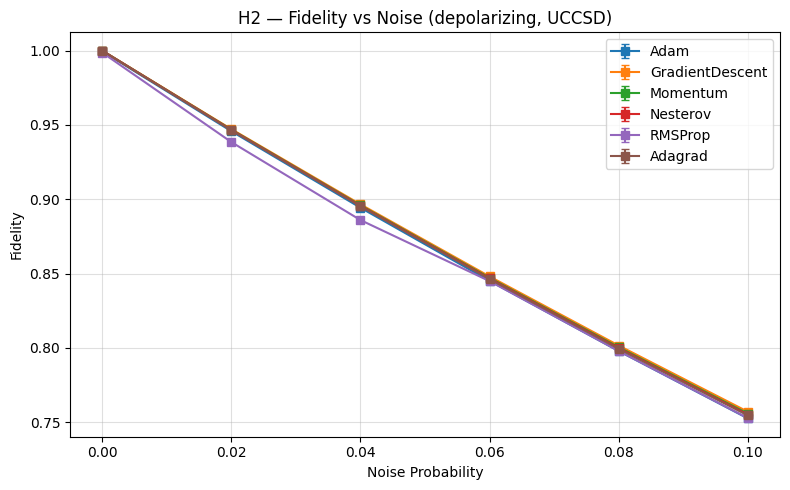

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2_noisy_optimizer_comparison_fidelity_ansUCCSD_noisedepolarizing.png

Depolarizing noise — robustness summary
---------------------------------------
optimizer           stepsize      AUC|ΔE|     AUC(1-F)       ΔE@max      F@max
------------------------------------------------------------------------------
GradientDescent        0.050     0.008835     0.012565     0.173784     0.7570
Momentum               0.100     0.008890     0.012637     0.174707     0.7557
Nesterov               0.100     0.008913     0.012675     0.175203     0.7551
Adagrad                0.200     0.008914     0.012710     0.175240     0.7545
Adam                   0.200     0.008960     0.012820     0.175241     0.7525
RMSProp                0.100     0.009297     0.013143     0.175548     0.7527


In [4]:
dep_results = run_vqe_optimizer_comparison(
    molecule=molecule,
    ansatz_name=ansatz_name,
    optimizers=optimizers,
    steps=steps,
    stepsize=stepsize_map,
    mode="noise_stats",
    noise_type="depolarizing",
    noise_levels=noise_levels,
    seeds=seeds,
    mapping=mapping,
    force=False,
    show=True,
    plot=True,
)

dep_summary = summarise_noise_stats(dep_results)
print_summary(dep_summary, title="Depolarizing noise — robustness summary")


## 4️⃣ Amplitude damping noise: optimizer comparison (multi-seed)

We now sweep amplitude damping probability `p` and set depolarizing to zero:

- `noise_type="amplitude"`

In [5]:
amp_results = run_vqe_optimizer_comparison(
    molecule=molecule,
    ansatz_name=ansatz_name,
    optimizers=optimizers,
    steps=steps,
    stepsize=stepsize_map,
    mode="noise_stats",
    noise_type="amplitude",
    noise_levels=noise_levels,
    seeds=seeds,
    mapping=mapping,
    force=False,
    show=True,
    plot=True,
)

amp_summary = summarise_noise_stats(amp_results)
print_summary(amp_summary, title="Amplitude damping — robustness summary")



⚙️ Optimizer: Adam (stepsize=0.2)
  🔹 Computing noiseless references per seed...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noiseless__s0__edc12961e9f5.json
  🔹 Sweeping noise levels...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noisy__s0__9866edc37348.json
    p_dep=0.00, p_amp=0.00: ΔE=0.000035 ± 0.000000, ⟨F⟩=0.9996 ± 0.0000
Step 01/25: E = -1.093296 Ha
Step 02/25: E = -1.112188 Ha
Step 03/25: E = -1.102988 Ha
Step 04/25: E = -1.101372 Ha
Step 05/25: E = -1.105015 Ha
Step 06/25: E = -1.109241 Ha
Step 07/25: E = -1.111912 Ha
Step 08/25: E = -1.109947 Ha
Step 09/25: E = -1.106493 Ha
Step 10/25: E = -1.107309 Ha
Step 11/25: E = -1.110542 Ha
Step 12/25: E = -1.112147 Ha
Step 13/25: E = -1.111644 Ha
Step 14/25: E = -1.110565 Ha
Step 15/25: E = -1.109988 Ha
Step 16/25: E = -1.110243 Ha
Step 17/25: E = -1.111064 Ha
Step 18/25: E = -1.111991 Ha
Step 19/25: E = -1.112431 Ha


KeyboardInterrupt: 